In [1]:
import tensorflow as tf
import os
import scipy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from vindy import SindyNetwork
from vindy.libraries import PolynomialLibrary
from vindy.layers import SindyLayer, VindyLayer
from vindy.distributions import Gaussian, Laplace
from vindy.callbacks import (
    SaveCoefficientsCallback,
)
from vindy.utils import add_lognormal_noise

2025-08-28 23:00:10.217774: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-28 23:00:10.858365: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-28 23:00:11.143611: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756414811.506509   23115 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756414811.794759   23115 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756414812.509766   23115 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

## Roessler System
The Roessler system is a system of three ordinary differential equations that describe a simple chaotic system. The equations are given by:

$$
\begin{align}
&\dot{z}_1 = -z_2 - z_3,  \\
&\dot{z}_2 = z_1 + a z_2, \\
&\dot{z}_3 = b + z_3(z_1-c),
\end{align}
$$

where $a = 0.2, b = 0.2, c = 5.7$.

In [2]:
def roessler(t, x0, a=0.2, b=0.2, c=5.7):
    x, y, z = x0
    return [-y - z, x + a * y, b + z * (x - c)]

## Problem Setup
Let's define some general script parameter.

In [3]:
sindy_type = "vindy"  # "sindy" or "vindy", if you either want a deterministic or probabilistic model for the dynamics, respectively.
model_name = "roessler"
seed = 29 # random seed
random_IC = True # use random initial conditions
random_coeff = True # use random parameters (model noise)
measurement_noise_factor = 0.01 # measurement noise factor
model_noise_factor = 0.1 # model noise factor
n_train = 30 # number of training trajectories
n_test = 4 # number of test trajectories

In [4]:
def generate_directories(model_name, sindy_type, scenario_info, outdir):
    # noise before derivative, model error, seed
    outdir = os.path.join(outdir, f"{model_name}", f"{sindy_type}")
    figdir = os.path.join(outdir, "figures", f"{scenario_info}")
    log_dir = os.path.join(
        outdir,
        '{model_name}', 'log', f'{scenario_info}',
    )
    weights_dir = os.path.join(outdir, "weights", f"{scenario_info}")
    # save figure
    for dir in [outdir, figdir, log_dir, weights_dir]:
        if not os.path.isdir(dir):
            os.makedirs(dir)

    return outdir, figdir, log_dir, weights_dir

In [5]:
scenario_info = f"{sindy_type}_nbd__me_{random_coeff}_{model_noise_factor}_seed_{seed}_noise_{measurement_noise_factor}"
_, _, _, weights_dir = generate_directories(model_name, sindy_type, scenario_info, "results")

## Data generation
First, we will generate the data for the Roessler system that we can use to train the VINDy model. We will use the `scipy.integrate.solve_ivp` function to solve the ODEs and generate the data.

In [6]:
# Roessler system parameters
a = 0.2
b = 0.2
c = 5.7

# initial conditions
x0 = -5
y0 = -5
z0 = 0
ic = [x0, y0, z0]
dim = 3
var_names = ["z_1", "z_2", "z_3"]

# time vector
t0, T, nt = 0, 24, 2000
t = np.linspace(t0, T, nt)
dt = t[1] - t[0]


# Generate initial conditions and parameters
if random_IC:
    np.random.seed(seed)
    x0 = np.concatenate(
        [np.random.normal(ic_, scale=2, size=(n_train + n_test, 1)) for ic_ in ic],
        axis=1,
    )
else:
    x0 = np.repeat(np.array([ic])[:, :, np.newaxis], n_train + 1, axis=2)

if random_coeff:
    np.random.seed(seed)
    a_samples = np.random.normal(a, a * model_noise_factor, size=n_train)
    b_samples = np.random.normal(b, b * model_noise_factor, size=n_train)
    c_samples = np.random.normal(c, c * model_noise_factor, size=n_train)
else:
    a_samples = [a]
    b_samples = [b]
    c_samples = [c]

# Generate data
x = np.array(
    [
        scipy.integrate.odeint(lambda x, t: roessler(t, x, a=a_, b=b_, c=c_), x0_, t)
        for i, (a_, b_, c_, x0_) in enumerate(
            zip(a_samples, b_samples, c_samples, x0[:n_train])
        )
    ]
)

# add measurement noise
x = np.array([add_lognormal_noise(x_, measurement_noise_factor)[0] for x_ in x])
x_test = np.array(
    [
        scipy.integrate.odeint(lambda x, t: roessler(t, x, a=a, b=b, c=c), x0_, t)
        for x0_ in x0[n_train:]
    ]
)

# calculate time derivatives
dxdt = [np.array(np.gradient(x_, dt, axis=0)) for x_ in x]
dxdt_test = [np.array(np.gradient(x_, dt, axis=0)) for x_ in x_test]

 Let's plot the data to see what it looks like

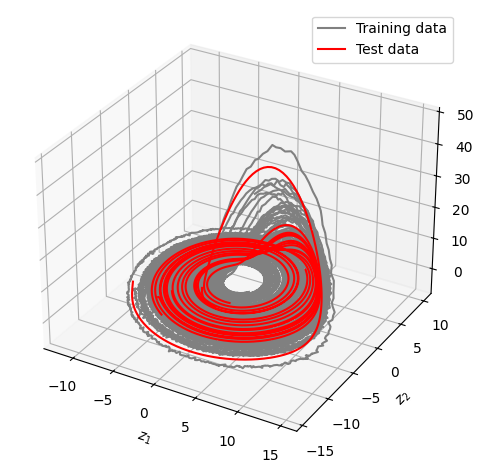

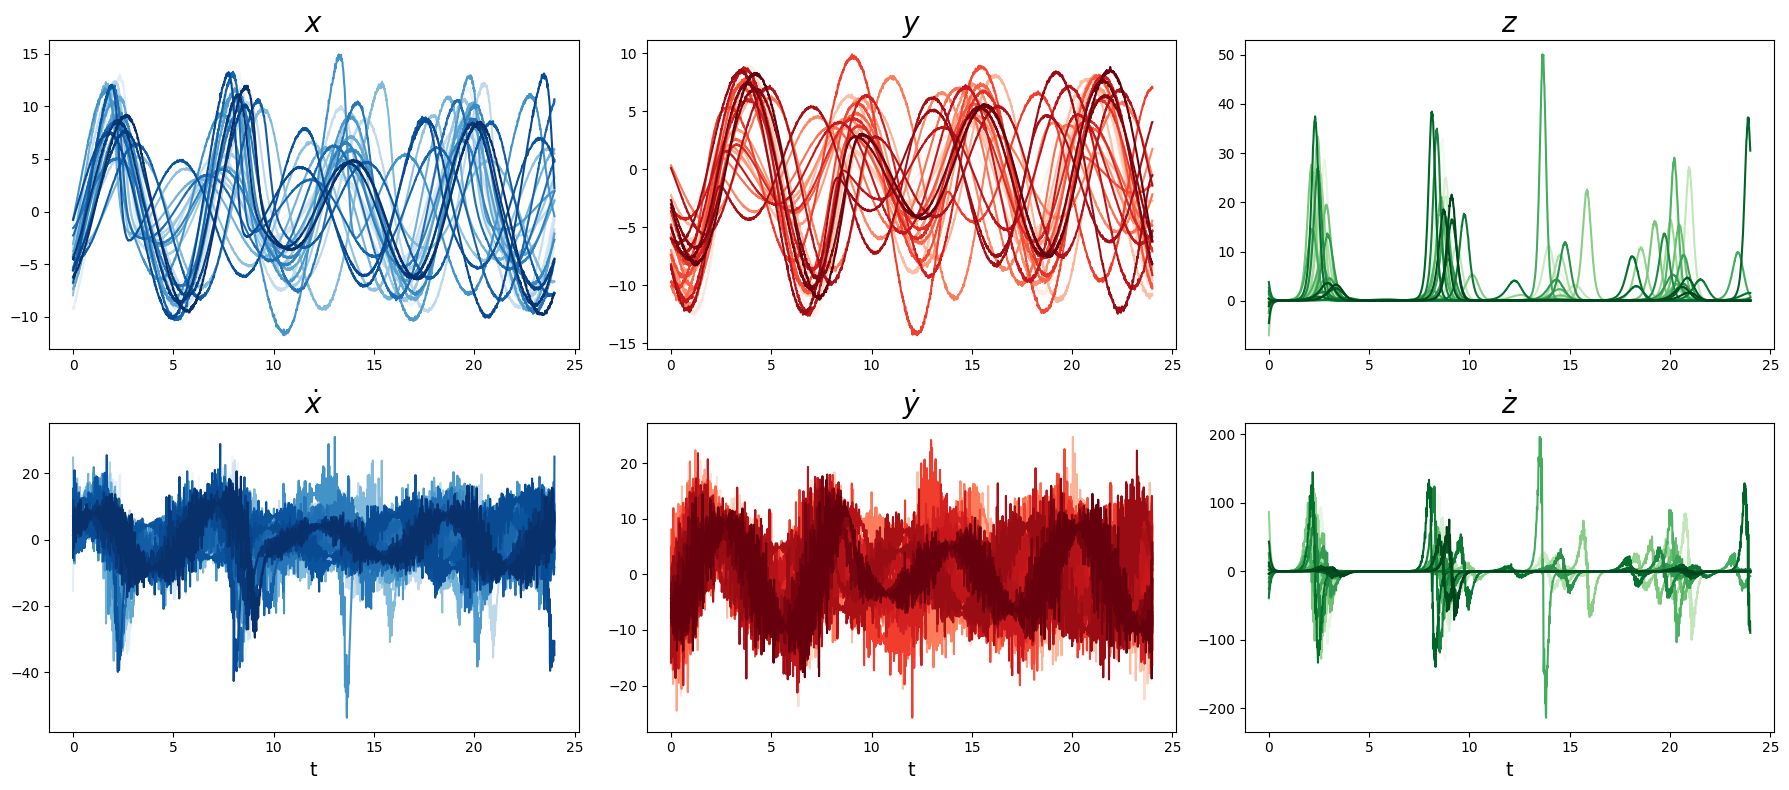

In [7]:
# three-dimensional plot of roessler attractor
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
for i, x_ in enumerate(x):
    if i == 0:
        ax.plot(x_[:, 0], x_[:, 1], x_[:, 2], c="gray", label="Training data")
    else:
        ax.plot(x_[:, 0], x_[:, 1], x_[:, 2], c="gray")
for i, x_ in enumerate(x_test):
    if i == 0:
        ax.plot(x_[:, 0], x_[:, 1], x_[:, 2], c="red", label="Test data")
    else:
        ax.plot(x_[:, 0], x_[:, 1], x_[:, 2], c="red")
plt.xlabel("$z_1$")
plt.ylabel("$z_2$")
ax.set_zlabel("$z_3$")
plt.legend()
plt.tight_layout()

# # Plot the training data
# Number of trajectories
num_trajectories = len(x)

# Colormap
cmap_blue = cm.Blues(np.linspace(0., 1, num_trajectories))
cmap_red  = cm.Reds(np.linspace(0., 1, num_trajectories))
cmap_green  = cm.Greens(np.linspace(0., 1, num_trajectories))

# Plot the training data
fig, axs = plt.subplots(2, 3, figsize=(18, 8))

# Plotting each trajectory for states and velocities
for i in range(num_trajectories):
    # States
    axs[0, 0].plot(t, x[i][:, 0], color=cmap_blue[i])
    axs[0, 1].plot(t, x[i][:, 1], color=cmap_red[i])
    axs[0, 2].plot(t, x[i][:, 2], color=cmap_green[i])

    # Velocities
    axs[1, 0].plot(t, dxdt[i][:, 0], color=cmap_blue[i])
    axs[1, 1].plot(t, dxdt[i][:, 1], color=cmap_red[i])
    axs[1, 2].plot(t, dxdt[i][:, 2], color=cmap_green[i])

# Setting labels and titles for states
axs[0, 0].set_title("$x$", fontsize=20)
axs[0, 1].set_title("$y$", fontsize=20)
axs[0, 2].set_title("$z$", fontsize=20)

# Setting labels
axs[1, 0].set_title("$\dot{x}$", fontsize=20)
axs[1, 1].set_title("$\dot{y}$", fontsize=20)
axs[1, 2].set_title("$\dot{z}$", fontsize=20)

for ax in axs[1, :]:
    ax.set_xlabel("t", fontsize=14)

plt.tight_layout()
plt.show()

## Model Generation

Now, we will define the VINDy model and train it on the generated data to learn the Roessler system. We will use the `VariationalSindyLayer` to define the model. The `VariationalSindyLayer` is a Bayesian version of the SINDy model that uses a variational inference approach to learn the model coefficients. We will use the `Laplacian` priors for the coefficients and use a polynomial library of degree 2 to learn the model.

In [8]:
# reshape data to fit the model
x_train = np.concatenate(x, axis=0)
dxdt_train = np.concatenate(dxdt, axis=0)
x_test = np.concatenate(x_test, axis=0)
dxdt_test = np.concatenate(dxdt_test, axis=0)

# model parameters
libraries = [
    PolynomialLibrary(2, include_bias=True),
]
dt = t[1] - t[0]

# create sindy layer
layer_params = dict(
    state_dim=x_train.shape[1],
    param_dim=0,
    feature_libraries=libraries,
    second_order=False,
    mask=None,
    kernel_regularizer=tf.keras.regularizers.L1L2(l1=0, l2=0),
)
if sindy_type == "vindy":
    sindy_layer = VindyLayer(
        beta=1e-3,
        priors=Laplace(0.0, 1.0),
        **layer_params,
    )
elif sindy_type == "sindy":
    sindy_layer = SindyLayer(
        **layer_params,
    )
else:
    raise ValueError(f"Unknown SINDy type: {sindy_type}")

# create autoencoder sindy model
model = SindyNetwork(
    sindy_layer=sindy_layer,
    x=x_train,
    l_dz=1e0,
    dt=dt,
    second_order=False,
)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="huber")

Let's train the VINDy model on the (noisy) Roessler data.
We aim to minimize the loss:
$$
\min_{\mathbf{W}_\mathbf{\Xi}} \frac{1}{n_s} \sum_{i=1}^{n_s} \lambda_1 ||\dot{\mathbf{x}} - \mathbf{\Theta}(\mathbf{x})\mathbf{\Xi}||_2^2+\lambda_2 \mathcal{KL}(q(\mathbf{\Xi}) || p(\mathbf{\Xi})),
$$

where

*   $\mathbf{x}=[x,y,z]^\top$ is the vector of the system states and $\dot{\mathbf{x}}$ its time derivatives.
*   $n_s$ is the total number of samples.
*   $\mathbf{\Theta}$ is the library of candidate features for describing the system dynamics.
*   $\mathbf{\Xi}\sim q(\Xi)=q(\Xi|\mathbf{x};\mathbf{W}_\mathbf{\Xi})$ is a matrix of random variables with posterior $q$ parametrized by $\mathbf{W}_\mathbf{\Xi}$. Priors on the entries of the matrix are set to be Laplacian distribution, i.e. $W_{ij}\sim \mathcal{L}(0,1)$.
*   $\lambda_1=1.0$, $\lambda_2=10^{-3}$ are the loss weighting coefficients.

In [ ]:
model.build(input_shape=[(None, x_train.shape[1]), (None, dxdt_train.shape[1])])

weights_path = os.path.join(weights_dir, ".weights.h5")

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(weights_path),
        save_weights_only=True,
        save_best_only=True,
        monitor="loss",
        verbose=0,
    ),
    SaveCoefficientsCallback()
]

# trainhist = model.fit(
#     x=[x_train, dxdt_train],
#     callbacks=callbacks,
#     y=None,
#     epochs=500,
#     batch_size=256,
#     verbose=1,
# )
# load best weights
model.load_weights(os.path.join(weights_path))
# apply pdf threshold
threshold = 0.5
sindy_layer.pdf_thresholding(threshold=threshold)

Epoch 1/500
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - dz: 1.2731 - kl_sindy: 0.1340 - loss: 1.4071 - reg: 0.0000e+00 - coeffs_mean: -0.1646 - coeffs_scale: -5.1316
Epoch 2/500
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - dz: 1.2750 - kl_sindy: 0.1338 - loss: 1.4088 - reg: 0.0000e+00 - coeffs_mean: -0.1662 - coeffs_scale: -5.1302
Epoch 3/500
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - dz: 1.2750 - kl_sindy: 0.1338 - loss: 1.4088 - reg: 0.0000e+00 - coeffs_mean: -0.1652 - coeffs_scale: -5.1263
Epoch 4/500
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - dz: 1.2735 - kl_sindy: 0.1337 - loss: 1.4072 - reg: 0.0000e+00 - coeffs_mean: -0.1650 - coeffs_scale: -5.1216
Epoch 5/500
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - dz: 1.2753 - kl_sindy: 0.1336 - loss: 1.4089 - reg: 0.0000e+00 - coeffs_mean: -0.1656 - coeffs_scale: -5.1219
Epoch 6/500
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - dz: 1.2771 - kl_sindy: 0.1336 - loss: 1.4107 - reg: 0.0000e+00 - coeffs_mean: -0.1654 - coeffs_scale: -5.1234
Epoch 7/50

INFO:root:Canceling coefficient 1 with pdf(0)=8.827963829040527
INFO:root:Canceling coefficient z_0 with pdf(0)=21.76030921936035
INFO:root:Canceling coefficient z_0^2 with pdf(0)=105.72167205810547
INFO:root:Canceling coefficient z_0*z_1 with pdf(0)=88.86980438232422
INFO:root:Canceling coefficient z_0*z_2 with pdf(0)=39.24951171875
INFO:root:Canceling coefficient z_1^2 with pdf(0)=180.8957977294922
INFO:root:Canceling coefficient z_1*z_2 with pdf(0)=48.53001403808594
INFO:root:Canceling coefficient z_2^2 with pdf(0)=243.02622985839844
INFO:root:Canceling coefficient 1 with pdf(0)=6.9449872970581055
INFO:root:Canceling coefficient z_2 with pdf(0)=30.234352111816406
INFO:root:Canceling coefficient z_0^2 with pdf(0)=199.31405639648438
INFO:root:Canceling coefficient z_0*z_1 with pdf(0)=111.44800567626953
INFO:root:Canceling coefficient z_0*z_2 with pdf(0)=65.34098052978516
INFO:root:Canceling coefficient z_1^2 with pdf(0)=156.9343719482422
INFO:root:Canceling coefficient z_1*z_2 with pd

dz0 = - 1.000*z1 - 0.994*z2 
dz1 = + 1.002*z0 + 0.204*z1 
dz2 = + 0.218*1 - 5.289*z2 + 0.967*z0*z2 - 0.018*z2^2 



Let's plot the training history of the VINDy model and check how the coefficients evolved during training.
We plot the coefficients of the VINDy model to see which terms are learned by the model.

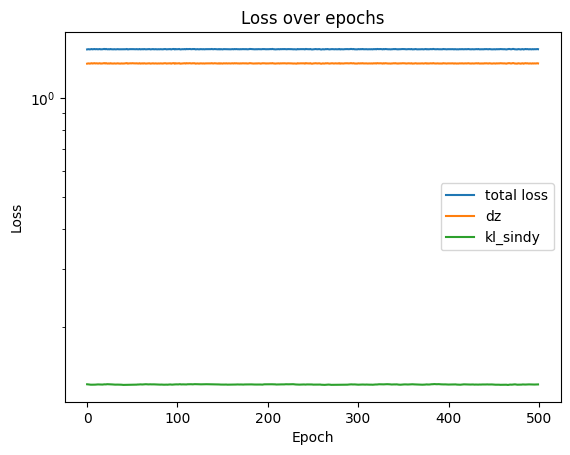

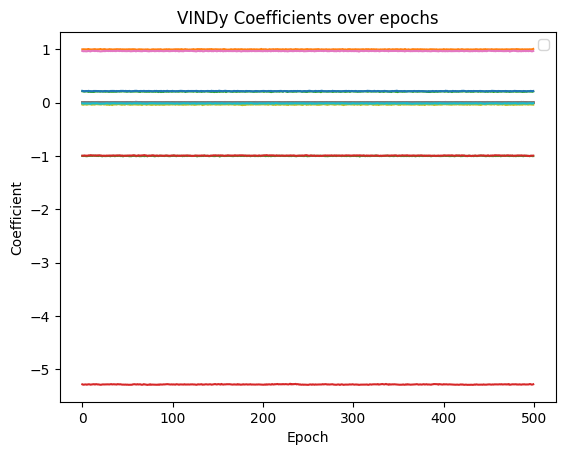

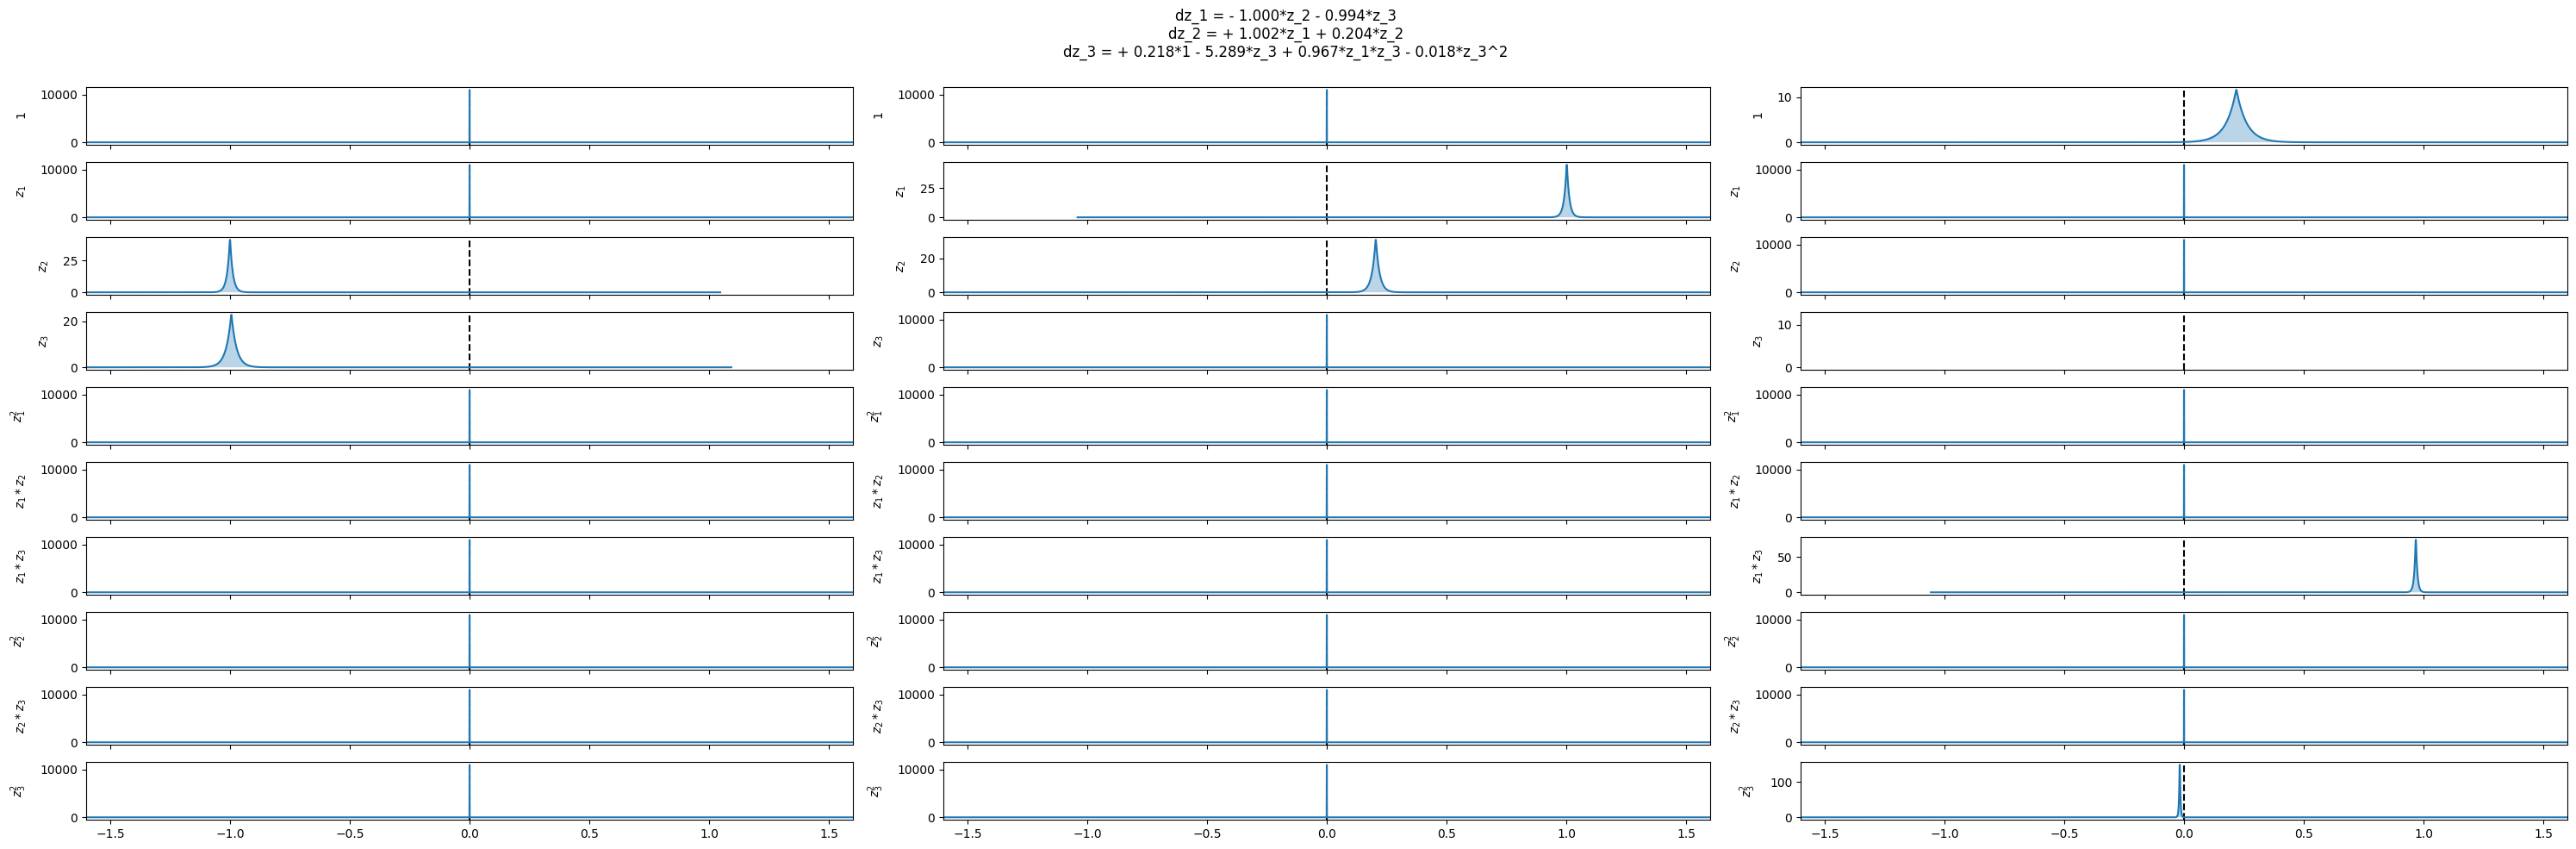

In [19]:
# plot training history
plt.figure()
plt.title("Loss over epochs")
plt.semilogy(trainhist.history["loss"])
plt.semilogy(trainhist.history["dz"])
plt.semilogy(trainhist.history["kl_sindy"])
plt.legend(["total loss", "dz", "kl_sindy"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.figure()
plt.title("VINDy Coefficients over epochs")
plt.plot(np.array(trainhist.history["coeffs_mean"]).squeeze())
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Coefficient")
plt.show()

equation = sindy_layer.model_equation_to_str(z=var_names, precision=3)
sindy_layer.visualize_coefficients(x_range=[-1.6, 1.6], z=var_names, mu=None)
plt.suptitle(equation)
plt.tight_layout()

We can now use the trained VINDy model to predict the future states of the Roessler system. We will use the `scipy.integrate.solve_ivp` function to integrate the ODEs using the predicted time derivatives.

z0: [-1.7243    -4.5584693  3.4227421]
t: [0.0000000e+00 1.2006003e-02 2.4012007e-02 ... 2.3975988e+01 2.3987993e+01
 2.4000000e+01]


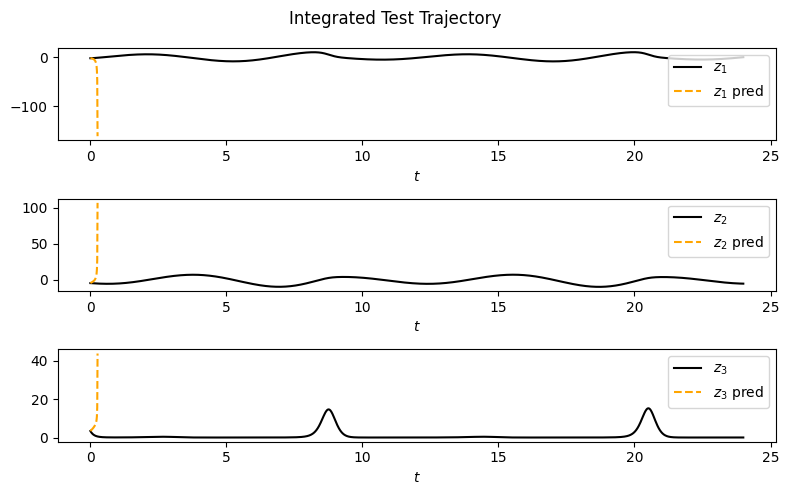

In [9]:
# %% integration
nt = t.shape[0]
i_test = 0
# integrate the model
t_0 = i_test * int(nt)
sol = model.integrate(x_test[t_0 : t_0 + 1].squeeze(), t.squeeze(), mu=None)
t_pred = sol.t
x_pred = sol.y

fig, axs = plt.subplots(dim, 1, figsize=(8, 5))
fig.suptitle(f"Integrated Test Trajectory")
t_0 = i_test * int(nt)
for i in range(dim):
    axs[i].plot(
        t, x_test[t_0 : t_0 + nt, i], label=f"${var_names[i]}$", color="black"
    )
    axs[i].plot(
        t_pred,
        x_pred[i],
        label=f"${var_names[i]}$ pred",
        linestyle="--",
        color="orange",
    )
    axs[i].set_xlabel("$t$")
    axs[i].legend(loc = 'upper right')
plt.tight_layout()